In [7]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
import time
from utilities import *
from GD import GradientDescent
from softmax_fun import SoftmaxRegression
from plot_fun import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#      data set 1

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data1()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1078, 64)
(449, 64)
(270, 64)


In [9]:
def find_best_hyper(arr_dics, X_train, y_train, X_val, y_val):
    '''
    Tune hyperparameters
    Args: arr_dic = array each element has a dict of parameters
    '''
    #stack train and validation to tune hyper
    X_rest = np.vstack((X_train, X_val))
    y_rest = np.vstack((y_train[:,None], y_val[:,None]))
    y_rest = y_rest.flatten()
    
   
    best_acc = 0.0
    best_run_time = np.inf
    loss_folds_train_arr = []
    loss_folds_val_arr = []
    acc_folds_train_arr = []
    acc_folds_val_arr = []
    acc_val_arr = []
    hyper_arr = []
    run_times = []
    
    for i in range(len(arr_dics)):
        accs = 0.0
        start_time = time.time()
        loss_folds_train = []
        loss_folds_val = []
        acc_folds_train = []
        acc_folds_val = []
        for f, (tr, val) in enumerate(cross_validate(X_rest.shape[0], 5)):
            optimizer = GradientDescent(**arr_dics[i], max_iters=100, record_history=True)
            model = SoftmaxRegression(reg = 0.1)

            x_tr = X_rest[tr]
            y_tr = y_rest[tr]
            xv = X_rest[val]
            yv = y_rest[val]
            model.fit(x_tr,y_tr, xv, yv, optimizer)

            loss_train = model.loss_train
            loss_val = model.loss_val
            loss_folds_train.append(loss_train)
            loss_folds_val.append(loss_val)
            
            acc_tr = model.train_accs
            acc_v = model.val_accs
            acc_folds_train.append(acc_tr)
            acc_folds_val.append(acc_v)
            
            y_pred_val = model.predict(xv)
            y_pred_val = np.argmax(y_pred_val, axis = 1)
            
            acc_val = accuracy(y_pred_val, yv)
            accs += acc_val
        accs /= (f+1)
        
        #representative condition
        if(accs > best_acc):
            best_acc = accs
            best_hyper = arr_dics[i]
            
            loss_folds_train_arr.append(loss_folds_train)
            loss_folds_val_arr.append(loss_folds_val)
            acc_folds_train_arr.append(acc_folds_train)
            acc_folds_val_arr.append(acc_folds_val)
            hyper_arr.append(best_hyper)
        
        run_time = time.time() - start_time
        run_times.append(run_time)
        acc_val_arr.append(accs)
        if(run_time < best_run_time):
            best_run_time = run_time
            best_hyper_time = arr_dics[i]
        print(arr_dics[i], ". acc:", accs, "run_time: ", run_time)
 
    print("best run time: ", best_run_time, "hyper: ", best_hyper_time)
    results = {}
    results['best_acc'] = best_acc
    results['best_hyper'] = best_hyper
    results['loss_folds_train_arr'] = loss_folds_train_arr
    results['loss_folds_val_arr'] = loss_folds_val_arr
    results['acc_folds_train_arr'] = acc_folds_train_arr
    results['acc_folds_val_arr'] = acc_folds_val_arr
    results['hyper_arr'] =  hyper_arr
    results['run_times'] =  run_times
    results['acc_val_arr'] = acc_val_arr 
    
    return results
    

In [10]:
learning_rate_arr = [0.5, 0.05, 0.005]
batch_size_arr = [128, 512, 1024]
beta_arr = [0.5, 0.7, 0.8]
arr_dics = build_grid(learning_rate_arr,  batch_size_arr, beta_arr)
results = find_best_hyper(arr_dics, X_train, y_train, X_val, y_val)

print("best hyperparameters: ", results['best_hyper'], "best acc: ", results['best_acc'])

{'learning_rate': 0.5, 'batch_size': 128, 'beta': 0.5} . acc: 0.5619672131147542 run_time:  2.308495044708252
{'learning_rate': 0.5, 'batch_size': 128, 'beta': 0.7} . acc: 0.7147540983606557 run_time:  1.9673888683319092
{'learning_rate': 0.5, 'batch_size': 128, 'beta': 0.8} . acc: 0.9055737704918034 run_time:  1.9009449481964111
{'learning_rate': 0.5, 'batch_size': 512, 'beta': 0.5} . acc: 0.6222950819672131 run_time:  1.129810094833374
{'learning_rate': 0.5, 'batch_size': 512, 'beta': 0.7} . acc: 0.6426229508196721 run_time:  1.156461238861084
{'learning_rate': 0.5, 'batch_size': 512, 'beta': 0.8} . acc: 0.7108196721311476 run_time:  1.1337451934814453
{'learning_rate': 0.5, 'batch_size': 1024, 'beta': 0.5} . acc: 0.6262295081967213 run_time:  1.2616558074951172
{'learning_rate': 0.5, 'batch_size': 1024, 'beta': 0.7} . acc: 0.6065573770491802 run_time:  1.2054038047790527
{'learning_rate': 0.5, 'batch_size': 1024, 'beta': 0.8} . acc: 0.6924590163934427 run_time:  1.1977729797363281
{

In [11]:
bh = results['best_hyper']
learning_rate_arr = [bh['learning_rate']]
batch_size_arr = [8, 16, 32, 64, 128, 256, 512, 1024]
beta_arr = [bh['beta']]
arr_dics = build_grid(learning_rate_arr,  batch_size_arr, beta_arr)
results2 = find_best_hyper(arr_dics, X_train, y_train, X_val, y_val)

{'learning_rate': 0.05, 'batch_size': 8, 'beta': 0.5} . acc: 0.8662295081967212 run_time:  27.48491907119751
{'learning_rate': 0.05, 'batch_size': 16, 'beta': 0.5} . acc: 0.9049180327868852 run_time:  13.281755924224854
{'learning_rate': 0.05, 'batch_size': 32, 'beta': 0.5} . acc: 0.9193442622950819 run_time:  6.31115984916687
{'learning_rate': 0.05, 'batch_size': 64, 'beta': 0.5} . acc: 0.9291803278688524 run_time:  3.2442996501922607
{'learning_rate': 0.05, 'batch_size': 128, 'beta': 0.5} . acc: 0.939672131147541 run_time:  2.1147301197052
{'learning_rate': 0.05, 'batch_size': 256, 'beta': 0.5} . acc: 0.9540983606557377 run_time:  1.2935302257537842
{'learning_rate': 0.05, 'batch_size': 512, 'beta': 0.5} . acc: 0.96 run_time:  1.1424479484558105
{'learning_rate': 0.05, 'batch_size': 1024, 'beta': 0.5} . acc: 0.9685245901639344 run_time:  1.1922430992126465
best run time:  1.1424479484558105 hyper:  {'learning_rate': 0.05, 'batch_size': 512, 'beta': 0.5}


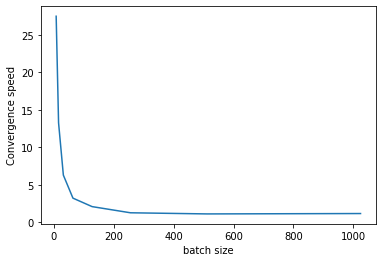

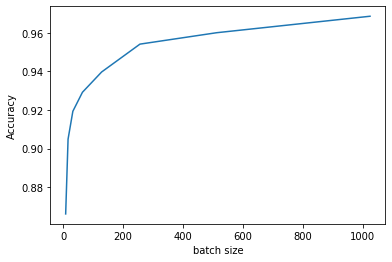

In [12]:
run_times = results2['run_times']
acc_val_arr = results2['acc_val_arr']
plt.plot(batch_size_arr, run_times)
plt.xlabel("batch size")
plt.ylabel("Convergence speed")
plt.show()

plt.plot(batch_size_arr, acc_val_arr)
plt.xlabel("batch size")
plt.ylabel("Accuracy")
plt.show()

{'learning_rate': 0.05, 'batch_size': 1024, 'beta': 0.5}


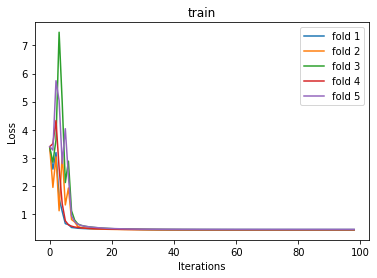

{'learning_rate': 0.05, 'batch_size': 1024, 'beta': 0.5}


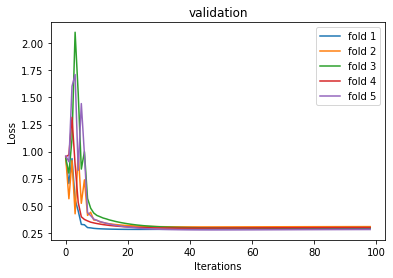

In [13]:
loss_folds_train_arr =  results['loss_folds_train_arr']
loss_folds_val_arr = results['loss_folds_val_arr']
hyper_arr = results['hyper_arr']
plot_folds(loss_folds_train_arr, "train", "Loss", hyper_arr)
plot_folds(loss_folds_val_arr, "validation", "Loss", hyper_arr)

{'learning_rate': 0.05, 'batch_size': 1024, 'beta': 0.5}


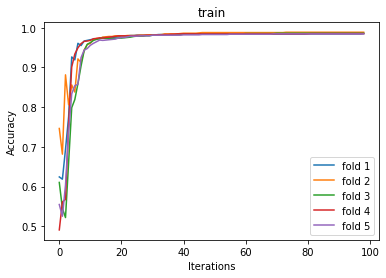

{'learning_rate': 0.05, 'batch_size': 1024, 'beta': 0.5}


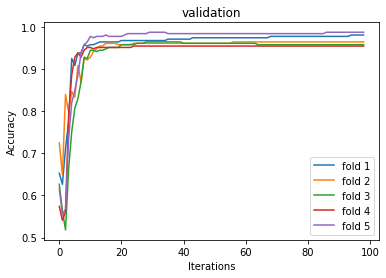

In [14]:
acc_folds_train_arr =  results['acc_folds_train_arr']
acc_folds_val_arr = results['acc_folds_val_arr']
plot_folds(acc_folds_train_arr, "train", "Accuracy", hyper_arr)
plot_folds(acc_folds_val_arr, "validation", "Accuracy", hyper_arr)

val accuracy:  0.9510022271714922


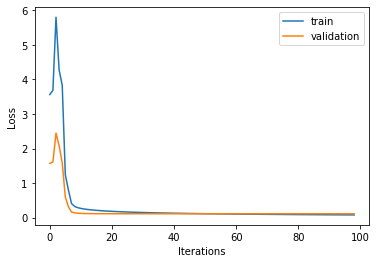

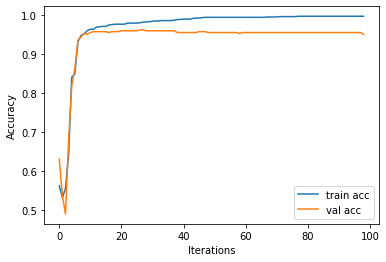

In [15]:
bh = results['best_hyper']
optimizer = GradientDescent(**bh, max_iters=100, record_history=True)
model = SoftmaxRegression()
model.fit(X_train,y_train, X_val, y_val, optimizer)

y_pred_val = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val, axis = 1)
acc_val = accuracy(y_pred_val, y_val)
print("val accuracy: ", acc_val)

loss_train_hist = model.loss_train
loss_val_hist = model.loss_val

iters = np.arange(len(loss_train_hist))
plot_loss(iters, loss_train_hist, loss_val_hist)

train_accs = model.train_accs
valid_accs = model.val_accs

plot_accuracy(iters, train_accs, valid_accs)

In [16]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis = 1)
acc_test = accuracy(y_pred_test, y_test)
print("accuracy in test: ", acc_test)

accuracy in test:  0.9740740740740741


# data set 1 with KNN sklearn

In [17]:
def find_best_hyper_sklearn(hps):
    best_acc = 0.0
    for n in hps:
        acc = 0
        for f, (tr, val) in enumerate(cross_validate(X_train.shape[0], 5)):
            neigh = KNeighborsClassifier(n_neighbors=n)
            x_tr = X_train[tr]
            y_tr = y_train[tr]
            xv = X_train[val]
            yv = y_train[val]
            neigh.fit(x_tr, y_tr)
            y_pred = neigh.predict(xv)
            acc_test = accuracy(y_pred, yv)
            acc += acc_test
        
        acc /= (f+1)
        
        if(acc > best_acc and n):
            best_acc = acc
            best_hyper = n
    
    return best_acc, best_hyper
    


In [18]:
n_neigh = [3, 5, 7, 9, 11, 20]      
best_acc, best_hyper = find_best_hyper_sklearn(n_neigh)  
print("best hyper:", best_hyper)
neigh = KNeighborsClassifier(n_neighbors=best_hyper)
neigh.fit(X_train, y_train)
y_pred_test = neigh.predict(X_test)
acc_test = accuracy(y_pred_test, y_test)
print("accuracy in test: ", acc_test)

best hyper: 3
accuracy in test:  0.9777777777777779


# data set 2

In [19]:
X_train2, y_train2, X_val2, y_val2, X_test2, y_test2 = load_data2()

print(X_train2.shape)
print(X_val2.shape)
print(X_test2.shape)

(648, 77)
(270, 77)
(162, 77)


In [20]:
learning_rate_arr = [0.5, 0.05]
batch_size_arr = [256, 512]
beta_arr = [0.5, 0.7]
arr_dics = build_grid(learning_rate_arr,  batch_size_arr, beta_arr)
results = find_best_hyper(arr_dics, X_train2, y_train2, X_val2, y_val2)

print("best hyperparameters: ", results['best_hyper'], "best acc: ", results['best_acc'])

{'learning_rate': 0.5, 'batch_size': 256, 'beta': 0.5} . acc: 0.35409836065573774 run_time:  43.55689096450806
{'learning_rate': 0.5, 'batch_size': 256, 'beta': 0.7} . acc: 0.37923497267759565 run_time:  43.384389877319336
{'learning_rate': 0.5, 'batch_size': 512, 'beta': 0.5} . acc: 0.4524590163934426 run_time:  54.18018889427185
{'learning_rate': 0.5, 'batch_size': 512, 'beta': 0.7} . acc: 0.48743169398907105 run_time:  50.194570779800415
{'learning_rate': 0.05, 'batch_size': 256, 'beta': 0.5} . acc: 0.38032786885245906 run_time:  49.607685804367065
{'learning_rate': 0.05, 'batch_size': 256, 'beta': 0.7} . acc: 0.38469945355191254 run_time:  56.47963809967041
{'learning_rate': 0.05, 'batch_size': 512, 'beta': 0.5} . acc: 0.47650273224043715 run_time:  50.847265005111694
{'learning_rate': 0.05, 'batch_size': 512, 'beta': 0.7} . acc: 0.47650273224043715 run_time:  46.868178367614746
best run time:  43.384389877319336 hyper:  {'learning_rate': 0.5, 'batch_size': 256, 'beta': 0.7}
best h

10 0.46296296296296297
20 0.5259259259259259
30 0.5703703703703704
40 0.6
50 0.6296296296296297
60 0.6518518518518519
70 0.6777777777777778
80 0.6925925925925926
90 0.7111111111111111
100 0.7222222222222222
110 0.7444444444444445
120 0.7444444444444445
130 0.7518518518518519
140 0.7518518518518519
150 0.7555555555555555
160 0.7666666666666667
170 0.7740740740740741
180 0.7777777777777778
190 0.7851851851851852
200 0.7925925925925926
210 0.7962962962962963
220 0.8037037037037037
230 0.8037037037037037
240 0.8037037037037037
250 0.8074074074074075
260 0.8074074074074075
270 0.8111111111111111
280 0.8111111111111111
290 0.8148148148148149
300 0.8148148148148149
310 0.8148148148148149
320 0.8148148148148149
330 0.8185185185185185
340 0.8222222222222223
350 0.8222222222222223
360 0.8148148148148149
370 0.8185185185185185
380 0.8185185185185185
390 0.8222222222222223
400 0.825925925925926
410 0.825925925925926
420 0.825925925925926
430 0.825925925925926
440 0.825925925925926
450 0.8259259259

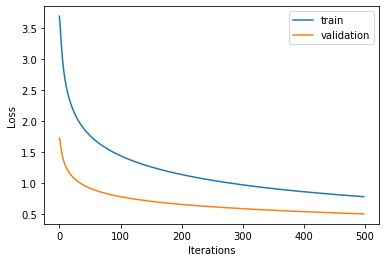

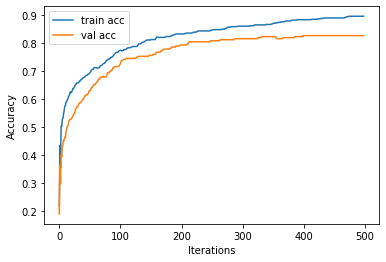

In [21]:
bh = results['best_hyper']
optimizer = GradientDescent(**bh, max_iters=500, record_history=True, print_hist = True)
model = SoftmaxRegression()
model.fit(X_train2,y_train2, X_val2, y_val2, optimizer)

y_pred_val = model.predict(X_val2)
y_pred_val = np.argmax(y_pred_val, axis = 1)
acc_val = accuracy(y_pred_val, y_val2)
print("val accuracy: ", acc_val)

loss_train_hist = model.loss_train
loss_val_hist = model.loss_val

iters = np.arange(len(loss_train_hist))
plot_loss(iters, loss_train_hist, loss_val_hist)

train_accs = model.train_accs
valid_accs = model.val_accs

plot_accuracy(iters, train_accs, valid_accs)

In [22]:
y_pred_test = model.predict(X_test2)
y_pred_test = np.argmax(y_pred_test, axis = 1)
acc_test = accuracy(y_pred_test, y_test2)
print("accuracy in test: ", acc_test)

accuracy in test:  0.8641975308641975


# Data set 2 with decision trees

In [23]:
max_depths = [20, 40, 60, 80, 100]      
best_acc, best_hyper = find_best_hyper_sklearn(max_depths)  
print("best hyper:", best_hyper)

clf = DecisionTreeClassifier(random_state=0, max_depth=best_hyper)
clf.fit(X_train2,y_train2)
y_pred_test = clf.predict(X_test2)
acc_test = accuracy(y_pred_test, y_test2)
print("accuracy in test: ", acc_test)



best hyper: 20
accuracy in test:  0.7777777777777777
